In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
from tqdm import tqdm
import random

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import torchvision

import librosa
import librosa.display
import IPython.display as ipd

%matplotlib inline

In [2]:
audio_path_root = '/home/therock/data2/GTZAN_audio/archive/Data/genres_original'
audio_sample_metal = audio_path_root + '/metal/metal.00024.wav'
audio_sample_metal_data , audio_sample_metal_sr = librosa.load(audio_sample_metal)

audio_sample_blues = audio_path_root + '/blues/blues.00024.wav'
audio_sample_blues_data , audio_sample_blues_sr = librosa.load(audio_sample_blues)

In [3]:
ipd.Audio(audio_sample_metal)

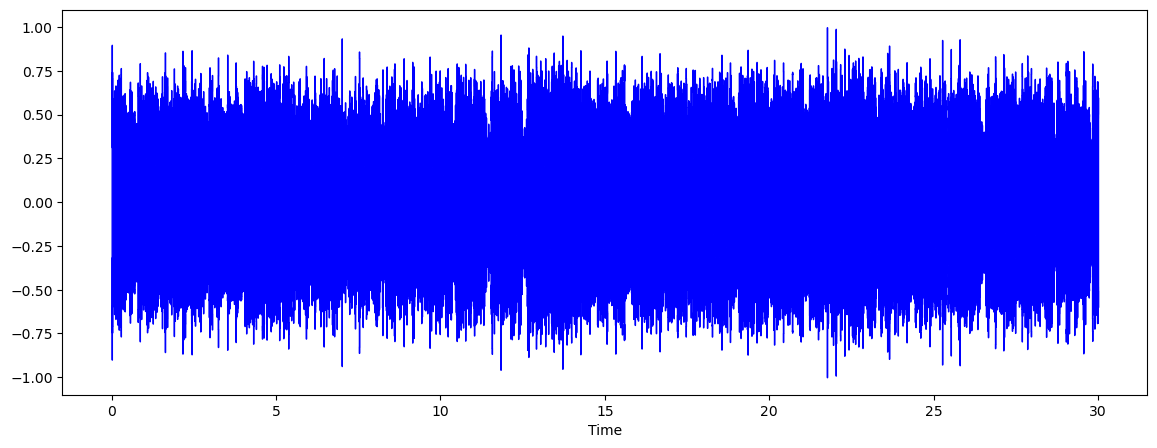

In [4]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_sample_metal_data, sr=audio_sample_metal_sr,color="blue")
plt.show()

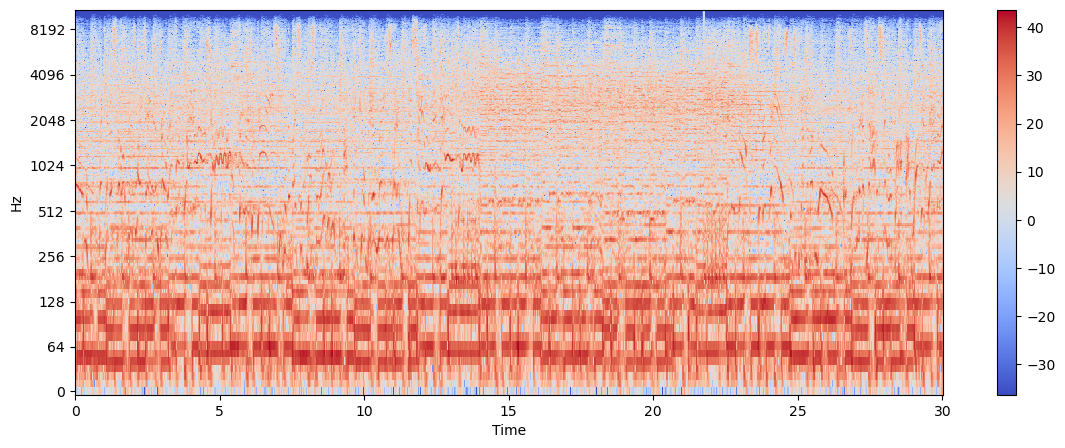

In [11]:
#display Spectrogram
X = librosa.stft(audio_sample_metal_data)
plt.figure(figsize=(14, 5))
# log of frequencies  
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=audio_sample_metal_sr, x_axis='time', y_axis='log')
plt.colorbar()

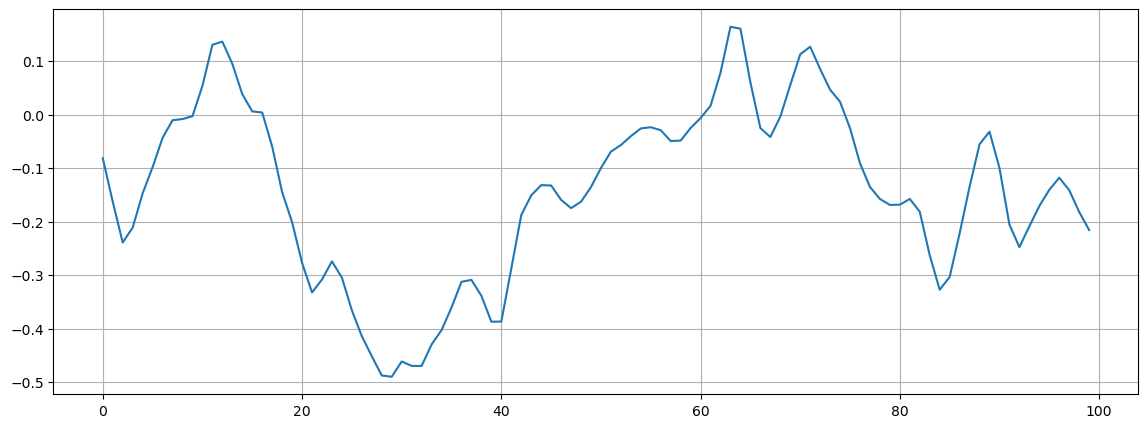

In [12]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(audio_sample_metal_data[n0:n1])
plt.grid()

In [13]:
zero_crossings = librosa.zero_crossings(audio_sample_metal_data[n0:n1], pad=False)
print(sum(zero_crossings))

6


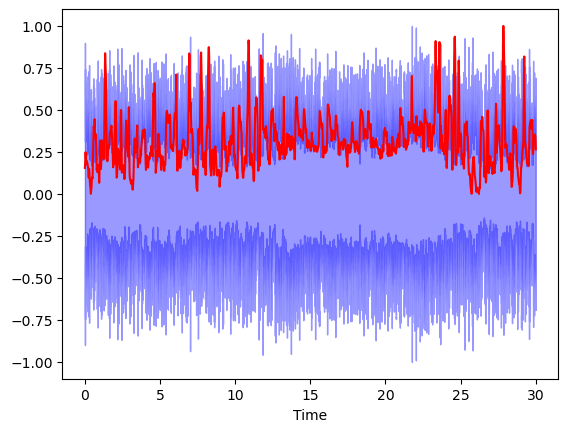

In [14]:
#spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound

spectral_centroids = librosa.feature.spectral_centroid(y=audio_sample_metal_data, sr=audio_sample_metal_sr)[0]
spectral_centroids.shape
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(audio_sample_metal_data, sr=audio_sample_metal_sr, alpha=0.4, color='blue')
plt.plot(t, normalize(spectral_centroids), color='r')

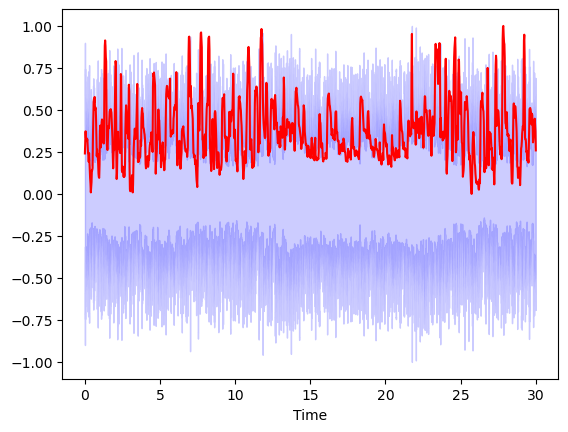

In [15]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_sample_metal_data, sr=audio_sample_metal_sr)[0]
librosa.display.waveshow(audio_sample_metal_data, sr=audio_sample_metal_sr, alpha=0.2, color='blue')
plt.plot(t, normalize(spectral_rolloff), color='r')

(20, 1293)


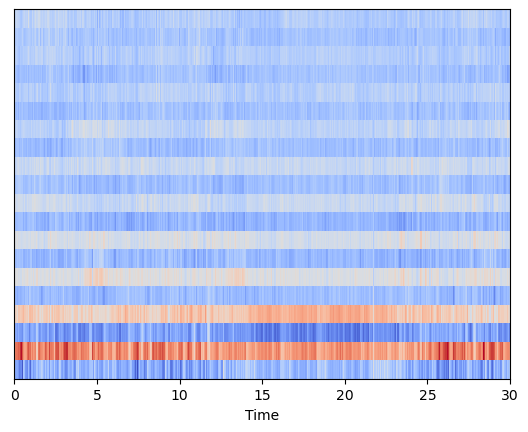

In [16]:
mfccs = librosa.feature.mfcc(y=audio_sample_metal_data, sr=audio_sample_metal_sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=audio_sample_metal_sr, x_axis='time')

[Text(0.5, 1.0, 'Mel-frequency spectrogram Metal')]

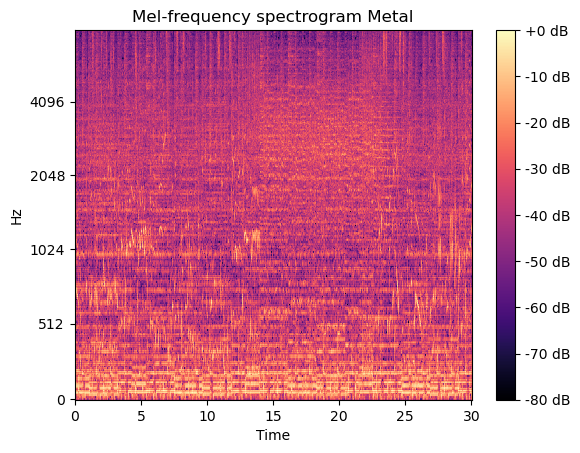

In [17]:
fig, ax = plt.subplots()
S = librosa.feature.melspectrogram(y=audio_sample_metal_data, sr=audio_sample_metal_sr, n_mels=512,
                                    fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=audio_sample_metal_sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram Metal')

[Text(0.5, 1.0, 'Mel-frequency spectrogram Blues')]

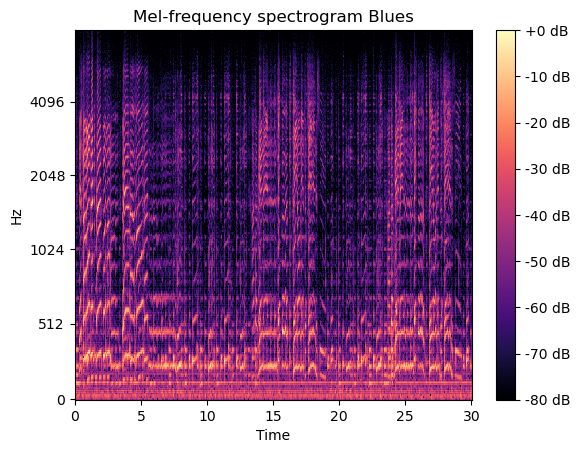

In [18]:
fig, ax = plt.subplots()
S = librosa.feature.melspectrogram(y=audio_sample_blues_data, sr=audio_sample_blues_sr, n_mels=512,
                                    fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=audio_sample_metal_sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram Blues')

# Extract audio features using Librosa

In [19]:
AUDIO_FEATURES_CSV_FILE = 'audio_features_data.csv'

In [21]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open(AUDIO_FEATURES_CSV_FILE, 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'{audio_path_root}/{g}'):
        songname = f'{audio_path_root}/{g}/{filename}'
        try:
            y, sr = librosa.load(songname, mono=True, duration=30)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rmse = librosa.feature.rms(y=y)[0]
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += f' {g}'
            file = open(AUDIO_FEATURES_CSV_FILE, 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())
        except:
            print(f"Skipping {songname}")

/tmp/ipykernel_33186/3852855751.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(songname, mono=True, duration=30)
/home/therock/anaconda3/envs/conda_torch/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping /home/therock/data2/GTZAN_audio/archive/Data/genres_original/jazz/jazz.00054.wav


In [23]:
audio_df_all = pd.read_csv(AUDIO_FEATURES_CSV_FILE)
audio_df = audio_df_all.drop(['filename'],axis=1)
audio_df.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.339061,0.098878,1443.268862,1670.239575,3069.306440,0.067194,-225.300308,117.641518,-14.544604,64.802383,...,3.049367,-7.628483,-8.961093,-4.351271,-0.065285,-2.553241,-3.436928,-3.867452,1.317023,blues
1,0.390160,0.136178,2279.265543,2375.084795,5198.476899,0.092570,-109.532349,86.926498,-8.624988,64.489502,...,11.086615,-5.094466,3.978770,-12.864775,12.342426,0.020587,-0.739240,-5.130450,3.307130,blues
2,0.288250,0.173309,1507.104729,2096.717628,3405.412741,0.045430,-171.810196,120.280624,15.327538,21.090450,...,-4.988853,-17.118925,-7.886534,-15.308929,-9.351315,-8.913866,-8.525090,-14.333636,-19.933725,blues
3,0.265896,0.168086,1513.520053,2140.702824,3449.845806,0.044378,-192.693832,111.188164,21.373314,26.392143,...,-5.045355,-17.632242,-7.920870,-15.150279,-12.345929,-17.235107,-7.781935,-13.042010,-17.948874,blues
4,0.342027,0.259655,2094.775834,2158.105747,4482.256230,0.100570,-30.129288,103.744797,-19.765732,56.411625,...,11.210426,-8.851257,9.101229,-3.574045,4.384885,-2.830827,4.726116,0.482424,1.477394,blues


## Label Encoding and features Scalling

In [24]:
genre_list = audio_df['label']
genre_encoder = LabelEncoder()
audio_df['label'] = genre_encoder.fit_transform(genre_list)
audio_df.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.339061,0.098878,1443.268862,1670.239575,3069.306440,0.067194,-225.300308,117.641518,-14.544604,64.802383,...,3.049367,-7.628483,-8.961093,-4.351271,-0.065285,-2.553241,-3.436928,-3.867452,1.317023,0
1,0.390160,0.136178,2279.265543,2375.084795,5198.476899,0.092570,-109.532349,86.926498,-8.624988,64.489502,...,11.086615,-5.094466,3.978770,-12.864775,12.342426,0.020587,-0.739240,-5.130450,3.307130,0
2,0.288250,0.173309,1507.104729,2096.717628,3405.412741,0.045430,-171.810196,120.280624,15.327538,21.090450,...,-4.988853,-17.118925,-7.886534,-15.308929,-9.351315,-8.913866,-8.525090,-14.333636,-19.933725,0
3,0.265896,0.168086,1513.520053,2140.702824,3449.845806,0.044378,-192.693832,111.188164,21.373314,26.392143,...,-5.045355,-17.632242,-7.920870,-15.150279,-12.345929,-17.235107,-7.781935,-13.042010,-17.948874,0
4,0.342027,0.259655,2094.775834,2158.105747,4482.256230,0.100570,-30.129288,103.744797,-19.765732,56.411625,...,11.210426,-8.851257,9.101229,-3.574045,4.384885,-2.830827,4.726116,0.482424,1.477394,0


In [27]:
audio_df_x = audio_df.drop(['label'],axis=1)
audio_df_y = audio_df['label']

scaler = StandardScaler()
cols = list(audio_df_x.columns)
audio_df_x[cols] = scaler.fit_transform(audio_df_x[cols])

audio_df_x = torch.tensor(audio_df_x.values, dtype=torch.float32)
audio_df_y = torch.tensor(audio_df_y.values, dtype=torch.long)

In [30]:
total_sample_size = (len(audio_df_y))
test_sample_size = 0.10 
valid_sample_size = 0.20

x_train, x_test, y_train, y_test = train_test_split(audio_df_x, audio_df_y, test_size=test_sample_size, shuffle=True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_sample_size, shuffle=True)

if total_sample_size == (len(x_train) + len(x_valid) + len(x_test)):
    print(f"train_data = {len(x_train)}, valid_data = {len(x_valid)}, test_data = {len(x_test)}")
else:
    print("error in splitting data correctly\n")

train_data = 719, valid_data = 180, test_data = 100


# ANN based model

In [31]:
class MusicGenreModel(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear1 = nn.Linear(in_features, 64)
        self.linear2 = nn.Linear(64, 1280)
        self.linear3 = nn.Linear(1280, 32)
        self.linear4 = nn.Linear(32, out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.10)

    def forward(self, x):
        x = self.dropout(self.relu(self.linear1(x)))
        x = self.dropout(self.relu(self.linear2(x)))
        x = self.dropout(self.relu(self.linear3(x)))
        x = self.dropout(self.relu(self.linear4(x)))

        return x

In [32]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [33]:
in_features = len(cols)
out_features = len(genre_encoder.classes_)
model = MusicGenreModel(in_features, out_features).to(device)
print(model)

MusicGenreModel(
  (linear1): Linear(in_features=26, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1280, bias=True)
  (linear3): Linear(in_features=1280, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [35]:
learning_rate = 0.003
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Model Training

In [43]:
epoch_count, train_acc_values, train_loss_values, valid_loss_values, valid_acc_values = [], [], [], [], []

epochs = 100
x_train = x_train.to(device)
y_train = y_train.to(device)

x_valid = x_valid.to(device)
y_valid = y_valid.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):

    model.train()
    
    y_logits = model(x_train).squeeze()
    y_pred = torch.max(y_logits.data, 1)[1]

    loss = loss_fn(y_logits, y_train)  # compute the loss
    acc = (y_pred == y_train).sum().item() / len(y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
        valid_logits = model(x_valid).squeeze()
        valid_pred = torch.max(valid_logits.data, 1)[1]
        valid_loss = loss_fn(valid_logits, y_valid)
        valid_acc = (valid_pred == y_valid).sum().item() / len(y_valid)

    # Print progress a total of 20 times
    if epoch % int(epochs / 20) == 0:
        print(f'Epoch: {epoch:4.0f} | Train Loss: {loss.cpu().detach().numpy()}, Accuracy: {acc:.2f}% |" Validation Loss: {valid_loss.cpu().detach().numpy()}, Accuracy: {valid_acc:.2f}%')


    epoch_count.append(epoch)
    train_loss_values.append(loss.cpu().detach().numpy())
    train_acc_values.append(acc)
    valid_acc_values.append(valid_acc)
    valid_loss_values.append(valid_loss.cpu().detach().numpy())


Epoch:    0 | Train Loss: 1.8622666597366333, Accuracy: 0.37% |" Validation Loss: 1.6870486736297607, Accuracy: 0.47%
Epoch:    5 | Train Loss: 1.527915596961975, Accuracy: 0.48% |" Validation Loss: 1.5057169198989868, Accuracy: 0.48%
Epoch:   10 | Train Loss: 1.4486072063446045, Accuracy: 0.56% |" Validation Loss: 1.4383610486984253, Accuracy: 0.52%
Epoch:   15 | Train Loss: 1.2911994457244873, Accuracy: 0.59% |" Validation Loss: 1.3714289665222168, Accuracy: 0.56%
Epoch:   20 | Train Loss: 1.2189078330993652, Accuracy: 0.62% |" Validation Loss: 1.2967630624771118, Accuracy: 0.57%
Epoch:   25 | Train Loss: 1.1072124242782593, Accuracy: 0.65% |" Validation Loss: 1.2892591953277588, Accuracy: 0.59%
Epoch:   30 | Train Loss: 1.0737719535827637, Accuracy: 0.66% |" Validation Loss: 1.2516157627105713, Accuracy: 0.59%
Epoch:   35 | Train Loss: 0.9660242199897766, Accuracy: 0.69% |" Validation Loss: 1.2393852472305298, Accuracy: 0.61%
Epoch:   40 | Train Loss: 0.9669066071510315, Accuracy: 0

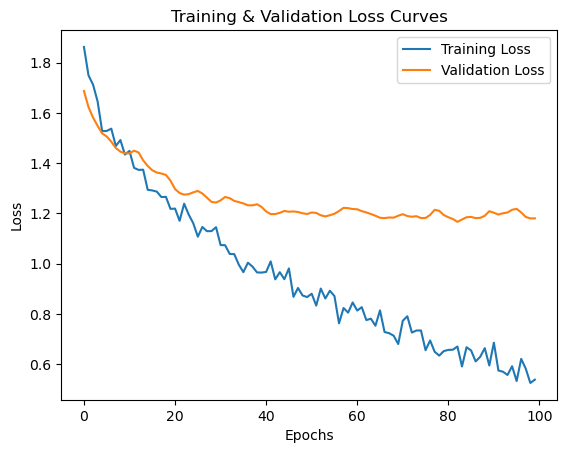

In [45]:
plt.plot(epoch_count, train_loss_values, label='Training Loss')
plt.plot(epoch_count, valid_loss_values, label='Validation Loss')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

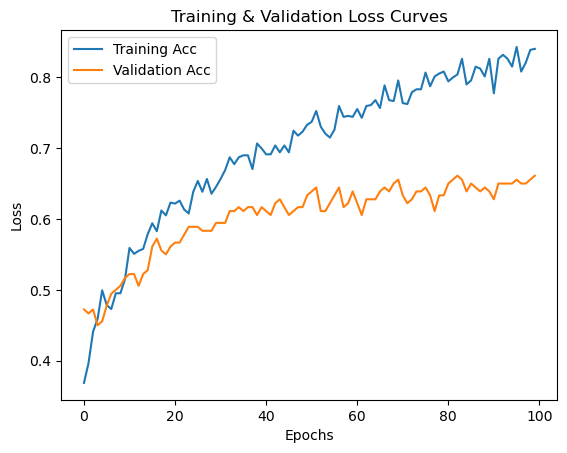

In [46]:
plt.plot(epoch_count, train_acc_values, label='Training Acc')
plt.plot(epoch_count, valid_acc_values, label='Validation Acc')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Testing the model

In [48]:
model.eval()

x_test = x_test.cpu()
y_test = y_test.cpu()

with torch.inference_mode():
    test_logits = model(x_test).squeeze()
    test_pred = torch.max(test_logits.data, 1)[1]
    acc = (test_pred == y_test).sum().item() / len(y_test)

print(f"Test accuracy = {acc}")

Test accuracy = 0.64


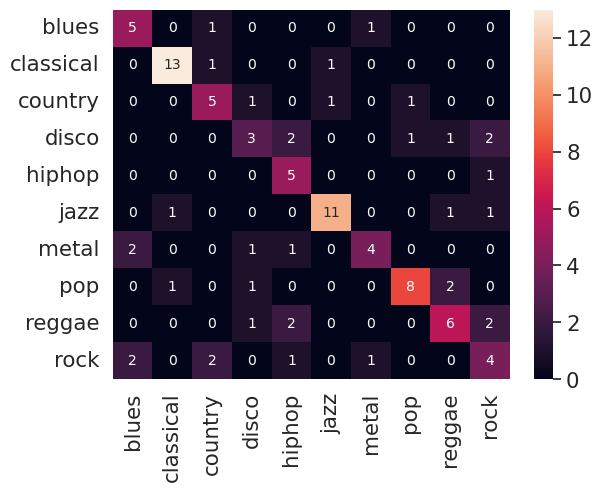

In [52]:
y_test = y_test.cpu()
test_pred = test_pred.cpu()

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, test_pred)
genre_classes_len = len(genre_encoder.classes_)
df_cm = pd.DataFrame(confusion_matrix, genre_encoder.classes_, genre_encoder.classes_)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size

plt.show()